In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Forward Propagation

### Network Architecture

- Input layer
- Number of hidden layers: $1$ with $n$ units
    + Activation function: sigmoid
- Output layer: $10$ units
    + Activation function: softmax

### Activation Function

For the one and only hidden layer, we use <b>sigmoid function</b> as the activation function. Sigmoid function is defined by the formula:

$$f(z_i) = \frac{1}{1 + e^{-z_i}}$$

where $z_i$ is a <b>linear transformation</b> for class $i$ $(1 \leq i \leq D^f)$

$$\mathbf{Z} = \mathbf{X} \mathbf{W^T} + \mathbf{b}$$

In [2]:
def linear_forward(X, W, b):
    Z = np.dot(X, W.T) + b
    return Z

In [3]:
def sigmoid(Z):
    A = 1. / (1 + np.exp(-Z))
    return A

To obtain the probabilities for each class in output layer, <b>softmax function</b> is applied as

$$f(z_i) = \frac{e^{z_i}}{\sum_{i = 1}^{D^f}e^{z_i}}$$

In [4]:
def softmax(Z):
    A = np.exp(Z - Z.max())        # Avoid overflow
    A = A / np.sum(A, axis=1, keepdims=True)
    return A

### Weights Initialisation

Random assignment is utilized to initialize weight matrices with small values ranging from -0.5 to 0.5 ($\alpha = 0.5$) while we use bias = 0 for all layers.

In [5]:
def init_params(num_layers, layer_dims, alpha=0.5, random_state=None):
    np.random.seed(random_state)
    W = [None] * num_layers
    b = [None] * num_layers
    diff_W = [None] * num_layers
    diff_b = [None] * num_layers
    
    for i in range(1, num_layers):
        W[i] = np.random.rand(layer_dims[i], layer_dims[i - 1]) - alpha
        b[i] = np.zeros((1, layer_dims[i]))
        diff_W[i] = np.zeros((layer_dims[i], layer_dims[i - 1]))
        diff_b[i] = np.zeros((1, layer_dims[i]))
        
    return W, diff_W, b, diff_b 

### Implemation

In [6]:
def forward_propagation(num_layers, X, W, b):
    A = [None] * num_layers
    Z = [None] * num_layers
    A[0] = X
    
    # Hidden layers
    i = 1
    while i < num_layers - 1:
        Z[i] = linear_forward(A[i - 1], W[i], b[i])
        A[i] = sigmoid(Z[i])
        i += 1
    
    # Output layer
    Z[i] = linear_forward(A[i - 1], W[i], b[i])
    A[i] = softmax(Z[i])
    
    return A, Z

## Loss Function

Let $\mathbf{t}$ be a vector of target labels and $\mathbf{y}$ be a vector of predicted label of the current model. Dissimilarity between $\mathbf{t}$ and $\mathbf{y}$ is measured by <b>cross entropy</b>, which is

$$\mathbf{L}(\mathbf{y}, \mathbf{t}) = -\sum_{i = 1}^{D^f}{t_i \log y_i}$$


In [7]:
def compute_cost(t, y):
    cost = -np.sum(np.multiply(np.log(y), t) + np.multiply(np.log(1 - y), 1 - t), axis=1)
    return np.mean(cost)

## Back Propagation

### Gradient Descent

To optimize weight $\theta$ used in the current model such that minimizes the loss function, which is the ultimate goal of learning for neural network, we use <b>gradient descent</b>. The algorithm works by repeated iterative throught two steps:

- Compute $\theta_{new} = \theta - \eta \nabla_{\theta} \mathbf{L} + \gamma \times (\theta - \theta_{old})$

- Update $\theta$ and get new $\mathbf{y}$


Derivatives are utilized in gradient descent in order to detect which one causes the most error and change parameters in that direction.

In [8]:
def error(y, A):
    return (A - y) / y.shape[0]

- Derivative of sigmoid function:

$$\frac{\delta f(z_i)}{\delta z_j} = \delta z_j \times f(z_i) \times (1 - f(z_i))$$

In [9]:
def dsigmoid(Z):
    A = sigmoid(Z)
    dZ = A * (1 - A)
    return dZ

- Derivative of weights and biases

In [10]:
def backward(dZ, A):
    dW = np.dot(dZ.T, A)
    db = np.sum(dZ, axis=0, keepdims=True)
    return dW, db

- Reverse Linear Transformation

In [11]:
def linear_backward(dZ, W):
    return np.dot(dZ, W)

### Parameter Update

In [12]:
def update_params(num_layers, learning_rate, momentum_factor, W, dW, diff_W, b, db, diff_b):
    for i in range(1, num_layers):
        new_W = W[i] - learning_rate * dW[i] + momentum_factor * diff_W[i]
        diff_W[i] = new_W - W[i]
        W[i] = new_W
        
        new_b = b[i] - learning_rate * db[i] + momentum_factor * diff_b[i]
        diff_b[i] = new_b - b[i]
        b[i] = new_b
        
    return W, diff_W, b, diff_b

### Implementation

In [13]:
def backward_propagation(num_layers, y, W, A, Z):
    dA = [None] * num_layers
    dZ = [None] * num_layers
    dW = [None] * num_layers
    db = [None] * num_layers
    
    # Gradient descent on output layer
    i = num_layers - 1
    dZ[i] = error(y, A[i])
    dW[i], db[i] = backward(dZ[i], A[i - 1])
    i -= 1
    
    # Gradient descent on hidden layers
    while i > 0:
        dA[i] = linear_backward(dZ[i + 1], W[i + 1])
        dZ[i] = dA[i] * dsigmoid(Z[i])
        dW[i], db[i] = backward(dZ[i], A[i - 1])
        i -= 1
        
    return dW, db

## Neural Network

### Implementation

In [14]:
from sklearn.metrics import accuracy_score

def simple_mlp(X_train, y_train, X_test, y_test, num_units,
               learning_rate=0.1, momentum_factor=0.9,
               num_epochs=1, return_cost=True, random_state=101):
    
    input_dim, num_classes = X.shape[1], y.shape[1]
    layer_dims = [input_dim, num_units, num_classes]
    num_layers = len(layer_dims)

    W, diff_W, b, diff_b = init_params(num_layers, layer_dims, 0.5, random_state)
    costs = []
    accuracies = []
    epochs = []
    
    for i in range(num_epochs):
        A, Z = forward_propagation(num_layers, X, W, b)
        cost = compute_cost(y, A[num_layers - 1])
        dW, db = backward_propagation(num_layers, y, W, A, Z)
        W, diff_W, b, diff_b = update_params(num_layers, learning_rate, momentum_factor,
                                             W, diff_W, dW, b, db, diff_b)

        # Predict
        A_test, Z_test = forward_propagation(num_layers, X_test, W, b)
        predictions = A_test[num_layers - 1]
    
        if i % 10 == 0:
            costs.append(cost)
            accuracies.append(accuracy_score(np.argmax(y_test, axis=1),
                                             np.argmax(predictions, axis=1)))
            epochs.append(i + 1)
    
    res = (W, b, costs, accuracies, epochs) if return_cost else (W, b)
    return res

### Experiments

In [15]:
import pandas as pd
data = pd.read_csv('./mnist/train.csv')
X, y = data.drop(columns='label').values, data['label'].values
print(X.shape, y.shape)

(42000, 784) (42000,)


<b>Preprocessing</b>:

- $X$: Pixel intensity values are firstly normalized to fall between 0 and 1 by dividing to maximum value of $X$ (255).

- $y$: One-hot encoding target vector to $N \times D_f$ matrix, where $N$ is the number of samples and $D_f$ is the number of classes.

In [16]:
# Preprocessing on X 
X = (X / X.max())

# Preprocessing on y
y = np.eye(y.max() - y.min() + 1)[y]

# Shape of the data after preprocessing
print(X.shape, y.shape)

(42000, 784) (42000, 10)


<b>Split data to train and test set</b> with ratio 8:2

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
def plot_cost_curve(costs, epochs, units='Costs', label=None, new_fig=False):
    if label is None:
        plt.plot(epochs, costs)
    else:
        plt.plot(epochs, costs, label=label)
        plt.legend()
        
    plt.xlabel('Epochs')
    plt.ylabel(units)
    
    if new_fig:
        plt.show()

<b>Experiments on both training and validation test in order to whether the network is overfitting</b>

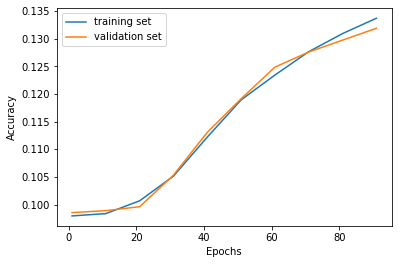

<Figure size 432x288 with 0 Axes>

In [30]:
W, b, cost_train, acc_train, epochs = simple_mlp(X_train, y_train, X_train, y_train, num_units=50,
                                                 learning_rate=0.1, momentum_factor=0.0, num_epochs=100)
W, b, cost_test, acc_test, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=50,
                                                learning_rate=0.1, momentum_factor=0.0, num_epochs=100)
plot_cost_curve(acc_train, epochs, 'Accuracy', 'training set')
plot_cost_curve(acc_test, epochs, 'Accuracy', 'validation set')
plt.show();
plt.savefig('acc_train_test.png');

<b>Experiments with different hidden dimensions:</b> 20, 50, 100

In [20]:
W, b, costs_20_units, acc_20_units, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=20, momentum_factor=0.0, num_epochs=100)
W, b, costs_50_units, acc_50_units, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, momentum_factor=0.0, num_epochs=100)
W, b, costs_100_units, acc_100_units, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=100, momentum_factor=0.0, num_epochs=100)

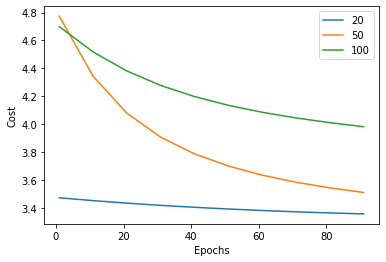

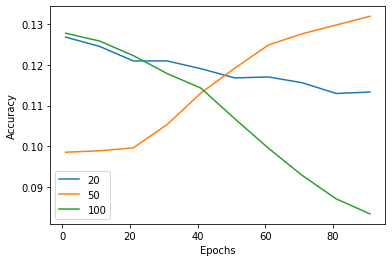

<Figure size 432x288 with 0 Axes>

In [21]:
plot_cost_curve(costs_20_units, epochs, 'Cost', '20')
plot_cost_curve(costs_50_units, epochs, 'Cost', '50')
plot_cost_curve(costs_100_units, epochs, 'Cost', '100')
plt.show();
plt.savefig('cost_different_hidden_units.png');

plot_cost_curve(acc_20_units, epochs, 'Accuracy', '20')
plot_cost_curve(acc_50_units, epochs, 'Accuracy', '50')
plot_cost_curve(acc_100_units, epochs, 'Accuracy', '100')
plt.show();
plt.savefig('acc_different_hidden_units.png');

<b>Experiments with different epochs:</b> 20, 50, 100

In [22]:
W, b, cost_20_epochs, acc_20_epochs, epochs_20 = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, momentum_factor=0.0, num_epochs=20)
W, b, cost_50_epochs, acc_50_epochs, epochs_50 = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, momentum_factor=0.0, num_epochs=50)
W, b, cost_100_epochs, acc_100_epochs, epochs_100 = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, momentum_factor=0.0, num_epochs=100)

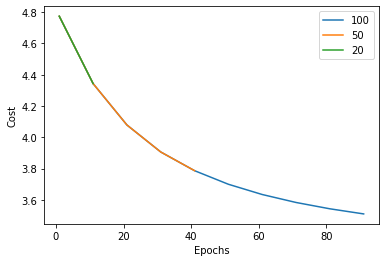

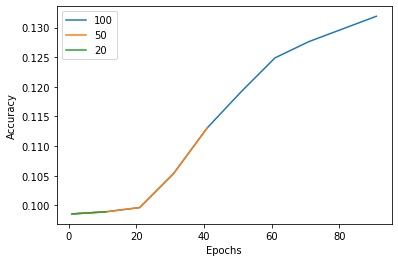

<Figure size 432x288 with 0 Axes>

In [23]:
plot_cost_curve(cost_100_epochs, epochs_100, 'Cost', '100')
plot_cost_curve(cost_50_epochs, epochs_50, 'Cost', '50')
plot_cost_curve(cost_20_epochs, epochs_20, 'Cost', '20')
plt.show();
plt.savefig('cost_different_epochs.png');

plot_cost_curve(acc_100_epochs, epochs_100, 'Accuracy', '100')
plot_cost_curve(acc_50_epochs, epochs_50, 'Accuracy', '50')
plot_cost_curve(acc_20_epochs, epochs_20, 'Accuracy', '20')
plt.show();
plt.savefig('acc_different_epochs.png');

<b>Experiments with different scaling factors:</b> 0-to-1, 0-to-255

In [24]:
W, b, cost_01_scale, acc_01_scale, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, momentum_factor=0.0, num_epochs=100)
W, b, cost_0255_scale, acc_0255_scale, epochs = simple_mlp(X_train * 255, y_train, X_test, y_test, num_units=50, momentum_factor=0.0, num_epochs=100)

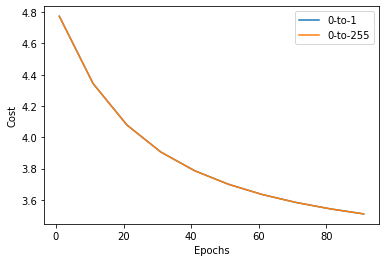

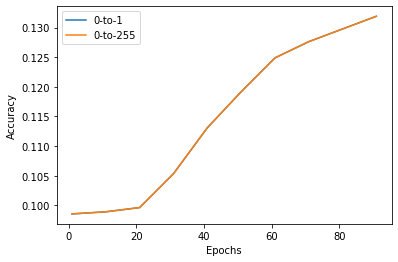

<Figure size 432x288 with 0 Axes>

In [25]:
plot_cost_curve(cost_01_scale, epochs, 'Cost', '0-to-1')
plot_cost_curve(cost_0255_scale, epochs, 'Cost', '0-to-255')
plt.show();
plt.savefig('cost_different_scaling_factor.png');

plot_cost_curve(acc_01_scale, epochs, 'Accuracy', '0-to-1')
plot_cost_curve(acc_0255_scale, epochs, 'Accuracy', '0-to-255')
plt.show();
plt.savefig('acc_different_scaling_factor.png');

<b>Experiments with different learning rates:</b> 0.1, 0.01, 0.001

In [26]:
W, b, cost_01_lr, acc_01_lr, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, learning_rate=0.1, momentum_factor=0.0, num_epochs=100)
W, b, cost_001_lr, acc_001_lr, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, learning_rate=0.01, momentum_factor=0.0, num_epochs=100)
W, b, cost_0001_lr, acc_0001_lr, epochs = simple_mlp(X_train, y_train, X_test, y_test, num_units=50, learning_rate=0.001, momentum_factor=0.0, num_epochs=100)

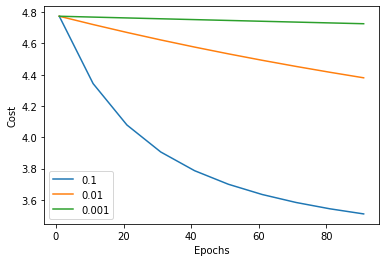

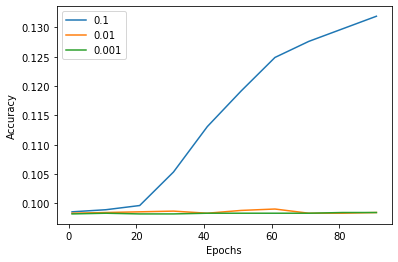

<Figure size 432x288 with 0 Axes>

In [27]:
plot_cost_curve(cost_01_lr, epochs, 'Cost', '0.1')
plot_cost_curve(cost_001_lr, epochs, 'Cost', '0.01')
plot_cost_curve(cost_0001_lr, epochs, 'Cost', '0.001')
plt.show();
plt.savefig('cost_different_learning_rate.png');

plot_cost_curve(acc_01_lr, epochs, 'Accuracy', '0.1')
plot_cost_curve(acc_001_lr, epochs, 'Accuracy', '0.01')
plot_cost_curve(acc_0001_lr, epochs, 'Accuracy', '0.001')
plt.show();
plt.savefig('acc_different_learning_rate.png');